In [1]:
import sys
sys.path.insert(1, '/home/zpengac/pose/EFARS/')

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import random
from datetime import datetime
import time
from torch.utils.data.sampler import SequentialSampler, RandomSampler

from models.openpose import OpenPose
from models.unipose import UniPose
from data.human36m import Human36M2DPoseDataset, Human36MMetadata
from utils.transform import do_pos2d_train_transforms, do_pos2d_val_transforms, denormalize
from utils.misc import AverageMeter, seed_everything
from utils.visualization import show_img_with_hmap

In [2]:
seed_everything(1120)

root_path = '/scratch/PI/cqf/datasets/h36m'
img_path = root_path + '/img'
pos2d_path = root_path + '/pos2d'

img_fns = glob(img_path+'/*.jpg')
random.shuffle(img_fns)
test_fns = img_fns[12000:14000]

In [3]:
test_dataset = Human36M2DPoseDataset(test_fns, pos2d_path, transforms=do_pos2d_train_transforms, mode='E', sigma=1)

In [4]:
from collections import OrderedDict
#net = UniPose(dataset='human3.6m',num_classes=17)
net = OpenPose()
checkpoint = torch.load('/home/zpengac/pose/EFARS/estimator/checkpoints/OpenPose-80-1e-4-sigma1/best-checkpoint-059epoch.bin', map_location=torch.device('cpu'))
state_dict = checkpoint['model_state_dict']
new_sd = OrderedDict()
for k, v in state_dict.items():
    new_sd[k[7:]] = v
net.load_state_dict(new_sd)
net.eval()

OpenPose(
  (model0): Sequential(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_1): ReLU(inplace=True)
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv1_2): ReLU(inplace=True)
    (pool1_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_1): ReLU(inplace=True)
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv2_2): ReLU(inplace=True)
    (pool2_stage1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_1): ReLU(inplace=True)
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu_conv3_2): ReLU(inplace=True)
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3)

In [5]:
den = lambda img: denormalize(img, Human36MMetadata.mean, Human36MMetadata.std)

In [6]:
img, hmap, skeleton = test_dataset[99]
img = img.unsqueeze(0)
_, pred = net(img)
pred = pred.squeeze().detach()
img = img.squeeze().detach()

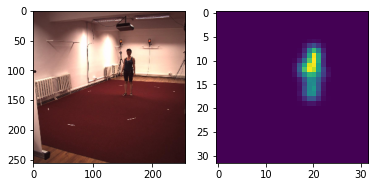

In [7]:
#pred[pred < 0.01] = 0
show_img_with_hmap(img, pred, den)

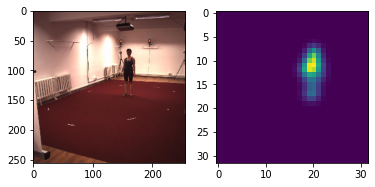

In [8]:
show_img_with_hmap(img, hmap, den)

In [9]:
np.square(hmap - pred).sum()

tensor(0.2771, dtype=torch.float64)

In [10]:
from utils.misc import accuracy
acc, acc_PCK, acc_PCKh, cnt, pred, visible = accuracy(pred.unsqueeze(0).numpy(), hmap.unsqueeze(0).cpu().numpy(), 0.2, 0.5)

In [11]:
print(f'Acc: {acc.mean()}, PCK: {acc_PCK.mean()}, PCKh: {acc_PCKh.mean()}')

Acc: 0.8719723183391004, PCK: 0.8719723183391004, PCKh: 0.8719723183391004
